<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_LSTM_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Objective

**Use a deep learning driven approach to build a crude palm oil preice predictor that takes monthly data over a certain date range as input, and outputs projected estimates for different time ranges in the future.**

In [ ]:
!pip install keras_tuner
!pip install tensorflow
!pip install keras-tuner --upgrade

###Load Libraries

In [406]:
import pandas as pd
import math
import keras
import os
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from kerastuner import BayesianOptimization
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import save_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from kerastuner.tuners import RandomSearch
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from keras.layers import Dense, Dropout
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
import keras_tuner
from kerastuner.engine.hyperparameters import HyperParameters
from pickle import dump,load
import warnings
warnings.simplefilter("ignore", UserWarning)

###Define Functions to Facilitate Metrics Evaluation

In [346]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [430]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/multivariate-time-series-prediction-of-crude-palm-oil-price-data-science-approach/main/cleaned_data/preprocessed.csv'
df = read_csv(path, index_col=0)
df.head()

,Date,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
0,2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
1,2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2,2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
3,2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
4,2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


In [431]:
df.index = pd.to_datetime(df['Date'], format='%Y.%m.%d')
del df['Date']

###Split Data into Train Test Segments

In [432]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 207
Test size: 23


###Plot Train Test Data

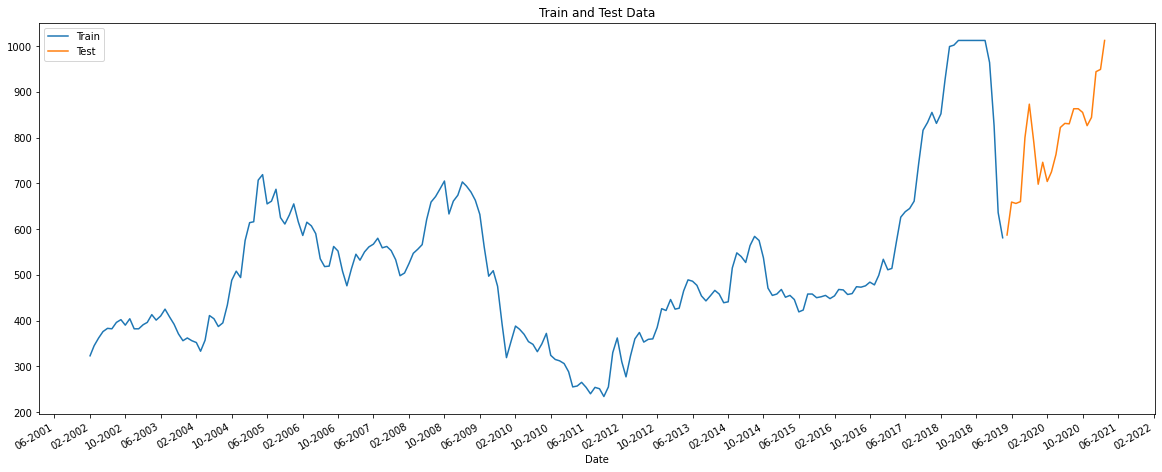

In [433]:
#Plotting data
plt.figure(figsize=(20,8))
plt.title("Train and Test Data")
plt.plot(train.index, train['cpo_pri'], label='Train')
plt.plot(test.index, test['cpo_pri'], label='Test')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=8))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

In [434]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

207 23


In [435]:
print(train.shape)
train.head()

(207, 6)


,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


###Rescale train dataset

In [436]:
f_transformer = MinMaxScaler()
feature_columns = ['cno_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'wti_spri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,0.210429,0.013238,0.218695,0.265091,0.109026
2002-03-01,345.0,0.323070,0.005303,0.183797,0.289974,0.044200
2002-04-01,362.0,0.383723,0.000000,0.120980,0.262164,0.006514
2002-05-01,376.0,0.434473,0.004228,0.040327,0.227035,0.000000
2002-06-01,383.0,0.560730,0.042041,0.044204,0.208007,0.010236


In [437]:
cpo_pri_transformer = MinMaxScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

Date
2002-02-01    0.114359
2002-03-01    0.142628
2002-04-01    0.164472
2002-05-01    0.182461
2002-06-01    0.191455
Name: cpo_pri, dtype: float64

In [438]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2019-05-01,587.0,0.563206,0.422889,0.930375,0.671342,0.331576
2019-06-01,659.0,0.555779,0.448122,0.820392,0.736243,0.364144
2019-07-01,656.0,0.480272,0.453614,0.760965,0.674401,0.415167
2019-08-01,660.0,0.420857,0.487240,0.754745,0.649621,0.462314
2019-09-01,800.0,0.571871,0.513956,0.675472,0.764331,0.545751


In [439]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

Date
2019-05-01    0.453582
2019-06-01    0.546097
2019-07-01    0.542242
2019-08-01    0.547382
2019-09-01    0.727273
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [440]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 1
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(206, 1, 6) (206,)


### LSTM Architecture

In [489]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.LSTM(units=40, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(tf.keras.layers.Dropout(rate=0.7))
lstm_model.add(tf.keras.layers.Dense(units=1))
lstm_model.compile(loss='mse', optimizer='adam')

In [490]:
lstm_history = lstm_model.fit(X_train, y_train,epochs=50,batch_size=20,validation_split=0.1,shuffle=False)

Epoch 1/50
10/10 [==============================] - 2s 52ms/step - loss: 0.1152 - val_loss: 0.6445
Epoch 2/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0776 - val_loss: 0.4856
Epoch 3/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0537 - val_loss: 0.3615
Epoch 4/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0414 - val_loss: 0.2696
Epoch 5/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0297 - val_loss: 0.2063
Epoch 6/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0294 - val_loss: 0.1690
Epoch 7/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0276 - val_loss: 0.1495
Epoch 8/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0268 - val_loss: 0.1426
Epoch 9/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0235 - val_loss: 0.1346
Epoch 10/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0215 - val_loss: 0.1291
Epoch 11/50
10/10 

In [491]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40)                7520      
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 41        
                                                                 
Total params: 7,561
Trainable params: 7,561
Non-trainable params: 0
_________________________________________________________________


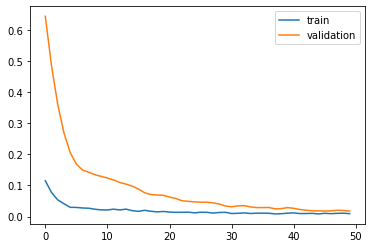

In [492]:
plt.plot(lstm_history.history['loss'], label='train')
plt.plot(lstm_history.history['val_loss'], label='validation')
plt.legend()
plt.show()

**Looking at the plot we can detect overfitting. There is room for improvement.**

In [493]:
y_pred = lstm_model.predict(X_test)
y_pred

array([[0.50141096],
       [0.5486094 ],
       [0.5194653 ],
       [0.50857854],
       [0.6270782 ],
       [0.71105623],
       [0.6451298 ],
       [0.567067  ],
       [0.622718  ],
       [0.57156515],
       [0.5928421 ],
       [0.63008344],
       [0.6744311 ],
       [0.68080413],
       [0.6781354 ],
       [0.71182215],
       [0.7100742 ],
       [0.69274855],
       [0.68738544],
       [0.7221334 ],
       [0.8123721 ],
       [0.8178524 ]], dtype=float32)

In [494]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[ 345.    362.    376.    383.    382.    396.    402.    390.    404.
   382.    382.    391.    396.    413.    401.    410.    425.    408.
   392.    371.    356.    362.    356.    352.    333.    357.    411.
   404.    387.    395.    434.    488.    508.    494.    575.    614.
   616.    707.    719.    655.    661.    687.    625.    611.    631.
   655.    616.    586.    615.    607.    590.    535.    518.    519.
   562.    552.    508.    476.    513.    545.    532.    550.    561.
   567.    580.    559.    562.    553.    533.    498.    504.    525.
   547.    556.    566.    621.    659.    671.    688.    705.    633.
   661.    674.    703.    694.    681.    663.    632.    561.    497.
   509.    475.    392.    319.    354.    388.    381.    370.    354.
   348.    332.    349.    372.    324.    315.    312.    306.    288.
   255.    257.    265.    254.    240.    254.    251.    234.    255.
   330.    362.    310.    277.    323.    360.    374.    353. 

In [495]:
y_train_inv = y_train_inv.flatten()
y_train_inv
y_test_inv = y_test_inv.flatten()
y_test_inv

array([ 659.  ,  656.  ,  660.  ,  800.  ,  873.  ,  789.  ,  698.  ,
        746.  ,  704.  ,  725.  ,  763.  ,  822.  ,  831.  ,  830.  ,
        863.  ,  863.  ,  855.  ,  826.  ,  844.  ,  944.  ,  949.  ,
       1012.25])

In [496]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([624.2231 , 660.95526, 638.2739 , 629.8013 , 722.0236 , 787.3795 ,
       736.07227, 675.31995, 718.6303 , 678.8206 , 695.3794 , 724.3625 ,
       758.87604, 763.8358 , 761.7589 , 787.9756 , 786.61523, 773.1316 ,
       768.95776, 796.0003 , 866.2286 , 870.4936 ], dtype=float32)

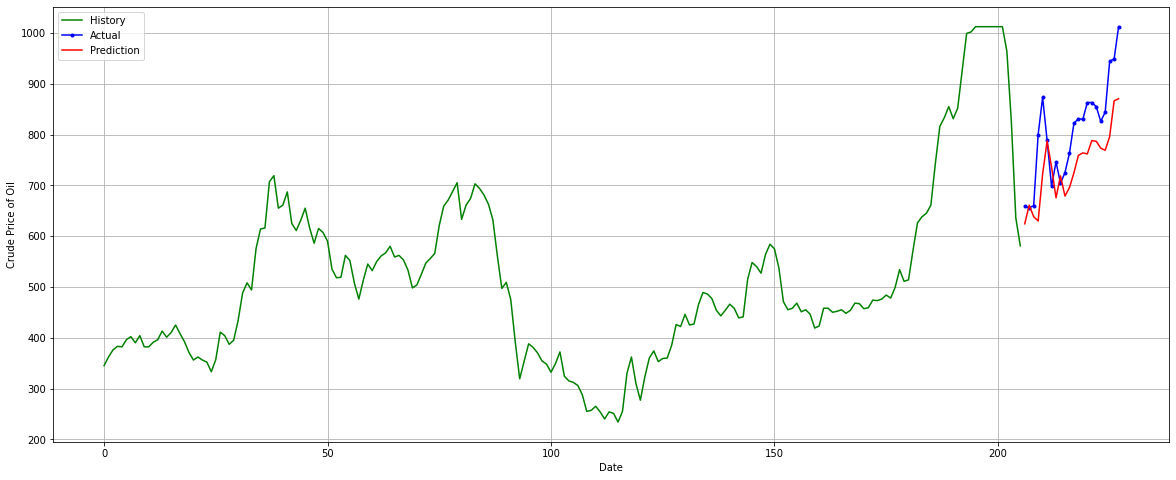

In [497]:
plt.figure(figsize=(20,8))
plt.grid()
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Price of Oil')
plt.xlabel('Date')
plt.legend()
plt.show();

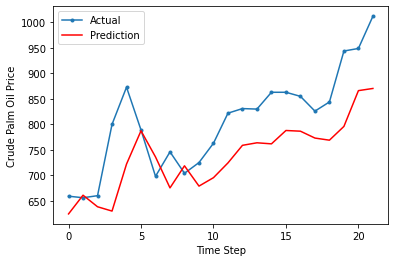

In [498]:
plt.plot(y_test_inv, marker='.', label="Actual")
plt.plot(y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

### Apply Random Search to get Best Hyperparameters

In [474]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import time
LOG_DIR = f"{int(time.time())}"

In [475]:
def build_model(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(tf.keras.layers.Dropout(rate=0.2))
  model.add(tf.keras.layers.Dense(units=1))
  model.compile(optimizer="adam",loss="mse", metrics=["accuracy"])
  
  return model

In [476]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=1,  # how many model variations to test?
    executions_per_trial=1,  # how many trials per variation? (same model could perform differently)
    directory=LOG_DIR)

In [477]:
tuner.search_space_summary()

Search space summary
Default search space size: 0


In [478]:
tuner.search(x=X_train,
             y=y_train,
             verbose=2, # just slapping this here bc jupyter notebook. The console out was getting messy.
             epochs=50,
             batch_size=64,
             #callbacks=[tensorboard],  # if you have callbacks like tensorboard, they go here.
             validation_data=(X_test, y_test))

Trial 1 Complete [00h 00m 05s]
val_accuracy: 0.04545454680919647

Best val_accuracy So Far: 0.04545454680919647
Total elapsed time: 00h 00m 05s
INFO:tensorflow:Oracle triggered exit


In [479]:
tuner.results_summary()

Results summary
Results in 1647568900/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
default configuration
Score: 0.04545454680919647


In [481]:
tuner.search(x=X_train,
             y=y_train,
             verbose=2,
             epochs=1,
             batch_size=20,
             validation_data=(X_test, y_test))

INFO:tensorflow:Oracle triggered exit


In [482]:
tuner.results_summary()

Results summary
Results in 1647568900/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
default configuration
Score: 0.04545454680919647


In [483]:
def build_model(hp):
    model = keras.Sequential()

    model.add(keras.layers.Dense(units=128,
                                 activation="relu",
                                 input_shape =(X_test.shape[1], X_test.shape[2])))

    for i in range(hp.Int('num_layers', 1, 6)):
      units = hp.Int(
          'units_' + str(i),
          min_value=8,
          max_value=64,
          step=8
      )
      model.add(keras.layers.Dense(units=units, activation='relu'))
      drop_rate = hp.Choice('drop_rate_' + str(i),
                            [
                              0.0, 0.1, 0.2, 0.3, 0.4,
                              0.5, 0.6, 0.7, 0.8, 0.9
                            ])
    model.add(keras.layers.Dropout(rate=drop_rate))

    model.add(keras.layers.Dense(1, activation='sigmoid'))
    #model.add(Flatten())

    model.compile(optimizer="adam",loss = 'mse', metrics = ['accuracy'])
    return model
#model = build_model()
#model.fit(X_train, y_train, batch_size=64, epochs = 50, validation_data = (X_test, y_test))

In [484]:
tuner = kt.RandomSearch(
    hypermodel = build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [485]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 8, 'sampling': None}
drop_rate_0 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'ordered': True}


In [486]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Trial 3 Complete [00h 00m 03s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 00m 11s
INFO:tensorflow:Oracle triggered exit


In [487]:
tuner.get_best_hyperparameters()[0].values

{'drop_rate_0': 0.7,
 'drop_rate_1': 0.0,
 'num_layers': 2,
 'units_0': 40,
 'units_1': 8}

In [488]:
tuner.results_summary()

Results summary
Results in my_dir/helloworld
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 2
units_0: 40
drop_rate_0: 0.7
units_1: 8
drop_rate_1: 0.0
Score: 0.0
Trial summary
Hyperparameters:
num_layers: 2
units_0: 64
drop_rate_0: 0.5
units_1: 40
drop_rate_1: 0.1
Score: 0.0
Trial summary
Hyperparameters:
num_layers: 4
units_0: 56
drop_rate_0: 0.3
units_1: 48
drop_rate_1: 0.2
units_2: 8
drop_rate_2: 0.0
units_3: 8
drop_rate_3: 0.0
Score: 0.0


In [384]:
MAX_TRIALS = 20
EXECUTIONS_PER_TRIAL = 5

In [386]:
b_tuner = BayesianOptimization(
    tune_nn_model,
    objective='val_accuracy',
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTIONS_PER_TRIAL,
    directory='test_dir',
    project_name='b_tune_nn',
    seed=7
)

In [387]:
import kerastuner as kt
from sklearn import ensemble
from sklearn import metrics
from sklearn import datasets
from sklearn import model_selection
def build_tree_model(hp):
  return ensemble.RandomForestClassifier(
      n_estimators=hp.Int('n_estimators', 10, 80, step=5),
      max_depth=hp.Int('max_depth', 3, 10, step=1),
      max_features=hp.Choice('max_features', ['auto', 'sqrt', 'log2'])
  )

In [388]:
sk_tuner = kt.tuners.Sklearn(
  oracle=kt.oracles.BayesianOptimization(
      objective=kt.Objective('score', 'max'),
      max_trials=MAX_TRIALS,
      seed=7
  ),
  hypermodel=build_tree_model,
  scoring=metrics.make_scorer(metrics.accuracy_score),
  cv=model_selection.StratifiedKFold(5),
  directory='test_dir',
  project_name='tune_rf'
)

In [391]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [396]:
sk_tuner.oracle.get_best_trials(num_trials=1).hyperparameters

AttributeError: ignored

In [326]:
def build_model(hp):

    model = Sequential()

    model.add(LSTM(hp.Int('input_units',
                          min_value=32,
                          max_value=256,
                          step=32),
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   return_sequences=True))

    model.add(LSTM(hp.Int('secondary_units',
                          min_value=32,
                          max_value=128,
                          step=32),
                   return_sequences=False))

    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1)))

    for i in range(hp.Int('n_layers', 1, 2)):
        model.add(Dense(hp.Int(f'dense_{i}_units',
                               min_value=8,
                               max_value=32,
                               step=8)))

    model.add(Dense(y_train.shape[0]))

    model.compile(optimizer='adam', loss='mse', metrics=['mse'])

    return model

In [332]:
import keras_tuner as kt
from tensorflow import keras

In [333]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="mse",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [334]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
input_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
secondary_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': None}
dense_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 32, 'step': 8, 'sampling': None}


In [335]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Trial 3 Complete [00h 00m 10s]
mse: 0.013060118071734905

Best mse So Far: 0.013060118071734905
Total elapsed time: 00h 00m 33s
INFO:tensorflow:Oracle triggered exit


In [336]:
tuner.get_best_hyperparameters()[0].values

{'dense_0_units': 16,
 'dense_1_units': 16,
 'dropout': 0.1,
 'input_units': 128,
 'n_layers': 2,
 'secondary_units': 64}

In [337]:
tuner.results_summary()

Results summary
Results in my_dir/helloworld
Showing 10 best trials
Objective(name='mse', direction='min')
Trial summary
Hyperparameters:
input_units: 128
secondary_units: 64
dropout: 0.1
n_layers: 2
dense_0_units: 16
dense_1_units: 16
Score: 0.013060118071734905
Trial summary
Hyperparameters:
input_units: 224
secondary_units: 64
dropout: 0.1
n_layers: 1
dense_0_units: 16
Score: 0.013571304269134998
Trial summary
Hyperparameters:
input_units: 96
secondary_units: 96
dropout: 0.30000000000000004
n_layers: 2
dense_0_units: 24
dense_1_units: 8
Score: 0.018071305938065052


###Apply Bayesian Optimization

In [153]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=hp.Int('units',min_value=8,
                                        max_value=64,
                                        step=8), 
                   activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(keras.layers.Dense(1))

    model.compile(loss='mse', optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
                   metrics=['mse'])
    return model

In [154]:
bayesian_opt_tuner = BayesianOptimization(
    build_model,
    objective='mse',
    max_trials=3,
    executions_per_trial=1,
    directory=os.path.normpath('C:/keras_tuning'),
    project_name='kerastuner_bayesian_poc',
    overwrite=True)

bayesian_opt_tuner.search(X_train, y_train,epochs=50,
     #validation_data=(X_test, y_test)
     validation_split=0.2,verbose=1)


bayes_opt_model_best_model = bayesian_opt_tuner.get_best_models(num_models=1)
model = bayes_opt_model_best_model[0]

Trial 3 Complete [00h 00m 04s]
mse: 0.06555971503257751

Best mse So Far: 0.0013938846532255411
Total elapsed time: 00h 00m 13s
INFO:tensorflow:Oracle triggered exit


In [155]:
bayesian_opt_tuner.get_best_hyperparameters()[0].values

{'learning_rate': 0.01, 'units': 24}

In [156]:
bayesian_opt_tuner.results_summary()

Results summary
Results in C:/keras_tuning/kerastuner_bayesian_poc
Showing 10 best trials
Objective(name='mse', direction='min')
Trial summary
Hyperparameters:
units: 24
learning_rate: 0.01
Score: 0.0013938846532255411
Trial summary
Hyperparameters:
units: 40
learning_rate: 0.01
Score: 0.0016199385281652212
Trial summary
Hyperparameters:
units: 8
learning_rate: 0.0001
Score: 0.06555971503257751


In [ ]:
def build_model(hp):

    model = Sequential()

    model.add(LSTM(hp.Int('input_units',
                          min_value=32,
                          max_value=256,
                          step=32),
                   input_shape=(X_test.shape[1], X_test.shape[2]),
                   return_sequences=True))

    model.add(LSTM(hp.Int('secondary_units',
                          min_value=32,
                          max_value=128,
                          step=32),
                   return_sequences=False))

    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1)))

    for i in range(hp.Int('n_layers', 1, 2)):
        model.add(Dense(hp.Int(f'dense_{i}_units',
                               min_value=8,
                               max_value=32,
                               step=8)))

    model.add(Dense(y_train.shape[0]))

    model.compile(optimizer='adam', loss='mse', metrics=['mse'])

    return model

In [ ]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [ ]:
bayesian_opt_tuner = BayesianOptimization(
    build_model,
    objective='mse',
    max_trials=3,
    executions_per_trial=1,
    directory=os.path.normpath('/content/bayes.txt'),
    project_name='kerastuner_bayesian_poc',
    overwrite=True)

bayesian_opt_tuner.search(X_train, y_train,epochs=200,
     #validation_data=(X_test, y_test)
     validation_split=0.2,verbose=1)

best_model = bayesian_opt_tuner.get_best_models(num_models=1)[0]
best_model.evaluate(X_test, y_test)

In [ ]:
tuner.get_best_hyperparameters()[0].values

In [ ]:
best_model.evaluate(X_test, y_test)

1/1 [==============================] - 2s 2s/step - loss: 0.0064 - mse: 0.0064


[0.006448349915444851, 0.006448349915444851]

In [ ]:
def build_model(hp):
    model = Sequential()
    #model = keras.Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(y_train.shape[1], activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model

In [ ]:
model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))

NameError: ignored

In [ ]:
model.fit(X_train, y_train, epochs=300, batch_size=50, verbose=1)

In [ ]:
for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))

NameError: ignored

In [ ]:
from tensorflow import keras
from kerastuner.tuners import BayesianOptimization

n_input = 6

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units',min_value=32,
                                    max_value=512,
                                    step=32), 
               activation='relu', input_shape=(n_input, 1)))
    model.add(Dense(units=hp.Int('units',min_value=32,
                                    max_value=512,
                                    step=32), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', metrics=['mse'], optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate',
                  values=[1e-2, 1e-3, 1e-4])))
    return model

In [ ]:
bayesian_opt_tuner = BayesianOptimization(
    build_model,
    objective='mse',
    max_trials=3,
    executions_per_trial=1,
    directory=os.path.normpath('C:/keras_tuning'),
    project_name='kerastuner_bayesian_poc',
    overwrite=True)

bayesian_opt_tuner.search(train_x, train_y,epochs=n_epochs,
     #validation_data=(X_test, y_test)
     validation_split=0.2,verbose=1)


bayes_opt_model_best_model = bayesian_opt_tuner.get_best_models(num_models=1)
model = bayes_opt_model_best_model[0]